# To study BNS lensing rate Vs redshift with MCMC sampling

In [1]:
import numpy as np
import bilby
import pylab as plt
from matplotlib import pyplot
import pycbc
from pycbc.detector import Detector
from datetime import datetime
from scipy.integrate import quad 

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
# for redshift to luminosity distance conversion
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
import astropy.units as u

* for calculation of $D_{hor}^{avg}$, refer to BNS_Range.ipynb 

# affect of lenisng magnification and red-shift
* considering optimal orientation and source location,
* both $D_l$ and $D_{hor}$ will affect the same by $\mu$.
* from BNS_Range.ipynb, 
$$ D_{hor}^{lensed} = \left( \frac{1 Mpc}{\rho_{th}^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z_{hor})\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} $$
* if a particular event has SNR$=\rho$ with luminosity distance ($D_l$)
$$ D_l^{lensed} = \left( \frac{1 Mpc}{\rho^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z)\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} $$

* for the event to be detectable, we need the condition $\rho^{lensed}\geq \rho_{th}^{lensed}$
$$ \left( \frac{1 Mpc}{D_l^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z)\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} \geq \left( \frac{1 Mpc}{D_{hor}^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z_{hor})\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu}$$
* with simplification,
$$ D_{hor}^{lensed}\left( \frac{1+z}{1+z_{hor}} \right)^{5/6} \geq D_l^{lensed} $$
$$ D_{hor}\left( \frac{1+z}{1+z_{hor}} \right)^{5/6} \geq D_l $$
* as $D_{hor}^{lensed}$ and $D_l^{lensed}$ affect the same way by lensing.

# for detectable BNS
* $$Bool\text{_}D_{hor} = \left\{\int_{2}^{\infty}\Theta[D_l(\mu,z)<D_{hor}(\mu,z)] P(\mu) d\mu \right\}$$
# $P(\mu)\Theta[D_l<\sqrt{\mu}D_{hor}]$ integration wrt $\mu$ (Single image detection)
* Probability desity function of lens amplification (SIS model): $P(\mu)=\frac{2}{(-1+\mu)^3}$
* $$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}]=\begin{cases}
        1 & c<\sqrt{\mu}\\
        \frac{1}{(-1+c^2)^2} & \text{otherwise}
    \end{cases}$$
* where $c=\frac{D_l}{D_{hor}}$


In [4]:
# considering only L1 
#for calculation of Dhor average, refer to BNS_Range.ipynb 
def Bool_lensed(z, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    if(dratio<=np.sqrt(2)):
        bool_lens = 1.
    else:
        bool_lens = (-1+dratio**2)**-2
    
    return(bool_lens)

# BBH/BNS merger rate
* merger rate as given in https://arxiv.org/abs/2204.12977: $ R(z,m) = R_0 g(z) f(m) \rho^{-1}$
* since we are considering only distance, mass pdf will integarte out to 1.
* therefore, $ R(z) = R_0 g(z) \rho^{-1}$
* z: redshift
* $\rho$: model dependent parameter
* $R_0$: local mereger rate of BNS, $13<R_0<1900$ $Gpc^{-3} yr^{-1}$
* $13<R_0<1900$ $Mpc^{-3}*10^{-9} yr^{-1}$
* $$ g(z)=C(1+z)^{\alpha}\left[ 1+\left( \frac{1+z}{1+z_p} \right)^{\alpha+\beta} \right]^{-1}$$
* $\rho=1,\alpha=2.7,\beta=2.9,z_p=1.9,\gamma=0,m_{min}=1,m_{max}=2.5$ for baseline model of BNS.

* let $R_O=100.$

In [6]:
def g_(z,a,b,zp):
    C = 1+(1+zp)**(-a-b) # ensures that g(z=0) = 1
    
    return( C*(1+z)**a * ( 1 + ((1+z)/(1+zp))**(a+b) )**(-1) )

# the value of local merger density rate R0 doesnt matter in the end as we are intersted only in rate ratio
def merger_rate_desity(z, R0=100.*1e-9, rho=1., a=2.7,b=2.9,zp=1.9,gamma=0,m_min=1,m_max=2.5):
    
    g = g_(z,a,b,zp)
    rate = R0*g*(rho**-1)
    return(rate)

* To plot the merger rate variation with red shift

# optical depth
* $\mathcal{D}_c$ : co-moving distance of the source
* as given in equation 18, https://arxiv.org/abs/2204.12977:
$$ \tau(z) = \left(\frac{\mathcal{D}_c(z)}{62.2Gpc}\right)^3 $$

In [14]:
def optical_depth(z):
    # z to luminosity_distance (Dl) conversion
    Dc = Planck18.comoving_distance(z).value*1e-3  # in Gpc
    return( (Dc/62.2)**3 )

# Differential comoving volume element 
* $ \frac{dV_c}{dz} $
* solid angle: $\Omega = \frac{A}{r^2}$
* integrate over the surface of a sphere: $\Omega = \frac{4 \pi r^2}{r^2} = 4 \pi$

In [15]:
def dVc_dz(z):
    return(4*np.pi*Planck18.differential_comoving_volume(z).value)

In [16]:
# checking units
Planck18.differential_comoving_volume(1)

<Quantity 2.86553105e+10 Mpc3 / sr>

# Rate of lensing

$$ R_L = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\tau(z)\frac{dV_c}{dz}\left\{\int_{2}^{\infty}\Theta[D_l(z)<D_{hor}(\mu)] P(\mu) d\mu \right\} $$

In [17]:
def integrand(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*Bool_lensed(z, dhor_) )

# R_L = quad(integrand, 0, np.inf, args=(dhor_original))[0]

# Unlensed events' rate

$$ R_U = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\frac{dV_c}{dz} \Theta[D_l(z)<D_{hor}^{original}] $$

In [18]:
def Bool_unlensed(z, dhor_ori):
    
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    return(int(Dl<dhor))

In [20]:
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

#R_U = quad(integrand2, 0, np.inf, args=(dhor_original))[0]

# Results

In [21]:
# results with varing Dhor = [20,10000]Mpc

dhor_original = np.linspace(20,10000,20)
R_sl = []
R_u = []
for ii in dhor_original:
    R_sl.append(quad(integrand, 0, np.inf, args=(ii))[0])
    R_u.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_sl = np.array(R_sl)
R_u = np.array(R_u)

In [22]:
R_sl

array([2.80339547e-08, 1.15630360e-02, 1.41783259e-01, 6.04649086e-01,
       1.66690817e+00, 3.60745528e+00, 6.68163095e+00, 1.10919441e+01,
       1.69673907e+01, 2.43524974e+01, 3.32061721e+01, 4.34094221e+01,
       5.47800743e+01, 6.70919269e+01, 8.00954555e+01, 9.35373805e+01,
       1.07177045e+02, 1.20798394e+02, 1.34217273e+02, 1.47284494e+02])

In [23]:
R_u

array([3.32503508e-03, 5.63926019e+01, 3.69925410e+02, 1.08538323e+03,
       2.29118397e+03, 4.04319992e+03, 6.37568711e+03, 9.30715685e+03,
       1.28438757e+04, 1.69821224e+04, 2.17097453e+04, 2.70073135e+04,
       3.28490375e+04, 3.84883529e+04, 4.60346908e+04, 5.33021552e+04,
       6.09622573e+04, 6.89687053e+04, 7.72733378e+04, 8.58269274e+04])

# relative difference between rate of lensed and unlensed events 

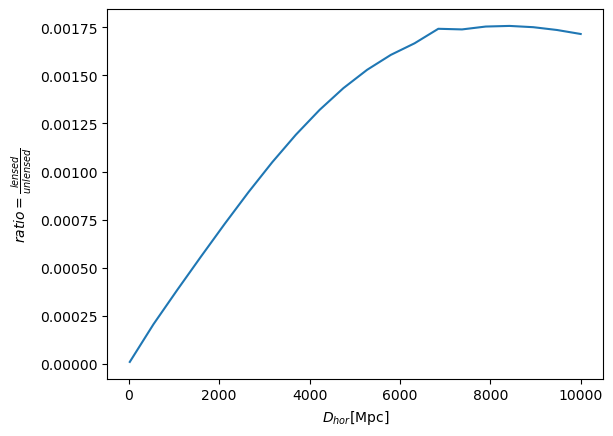

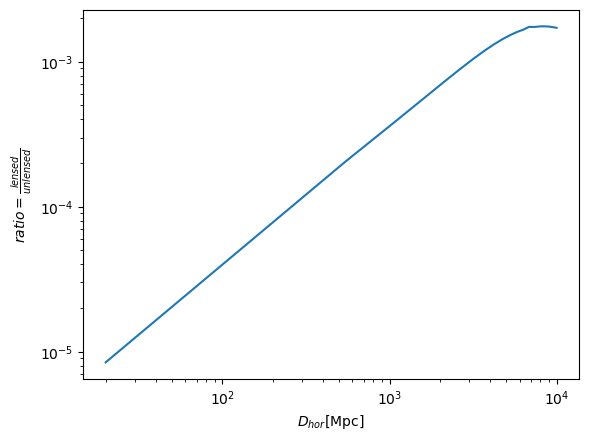

In [79]:
ratio_ = R_sl/R_u
plt.plot(dhor_original, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$D_{hor}$[Mpc]")
plt.show()
plt.loglog(dhor_original, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$D_{hor}$[Mpc]")
plt.show()

In [25]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

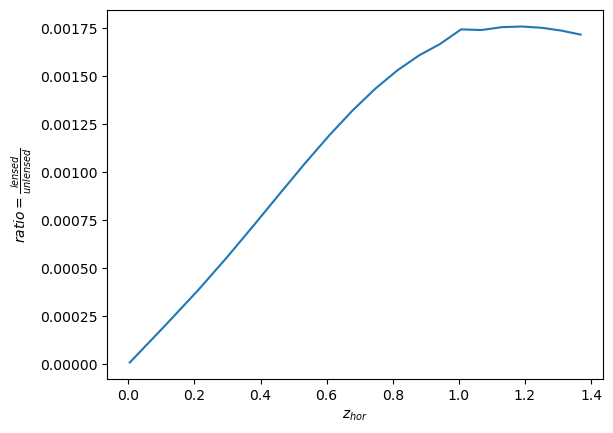

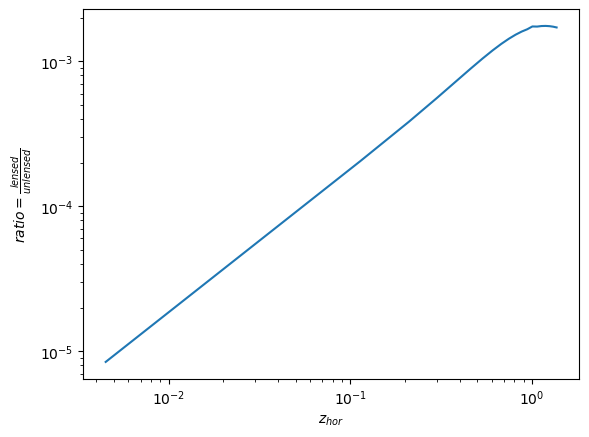

In [26]:
ratio_ = R_sl/R_u
plt.plot(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()
plt.loglog(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()

## taking a closer look at z<1.(6791.2689423031325Mpc)

In [28]:
# results with varing Dhor = [20,10000]Mpc

dhor_original = np.linspace(20,6791.2689423031325,20)
R_sl = []
R_u = []
for ii in dhor_original:
    R_sl.append(quad(integrand, 0, np.inf, args=(ii))[0])
    R_u.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_sl = np.array(R_sl)
R_u = np.array(R_u)

In [29]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

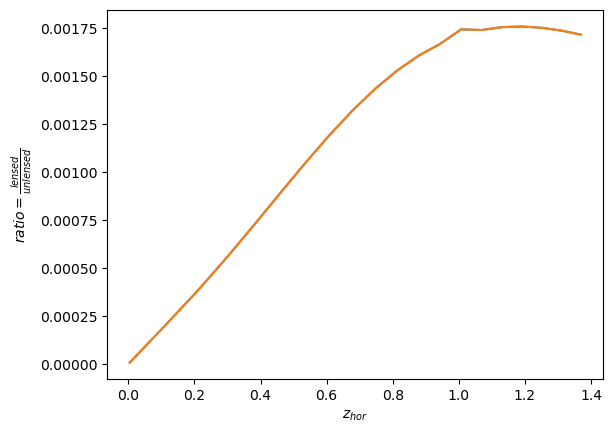

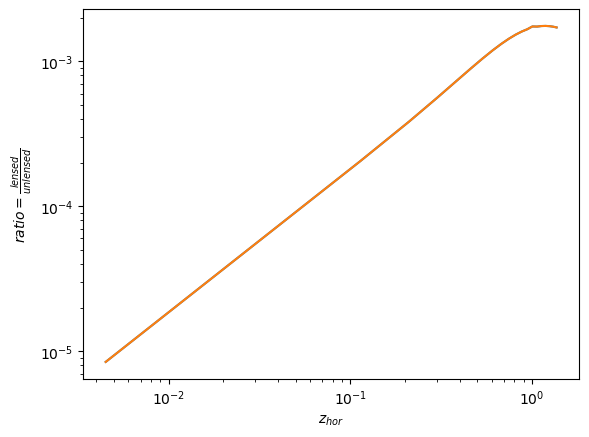

In [30]:
ratio_ = R_sl/R_u
plt.plot(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()
plt.loglog(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()

* logarithmic dependence can be seen

# $P(\mu)\Theta[D_l<\sqrt{\mu}D_{hor}]$ integration wrt $\mu$ (Double image detection)
* Probability desity function of lens amplification (SIS model): $P(\mu)=\frac{2}{(1+\mu)^3}$
* $$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}]=\begin{cases}
        1 & c<0.\\
        \frac{1}{(1+c^2)^2} & \text{otherwise}
    \end{cases}$$
* where $c=\frac{D_l}{D_{hor}}$

In [69]:
# considering only L1 
def Bool_lensed(z, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    if(dratio<=0.):
        bool_lens = 1.
    else:
        bool_lens = (1+dratio**2)**-2
    
    return(bool_lens)

In [70]:
# results with varing Dhor = [20,10000]Mpc

dhor_original = np.linspace(20,10000,20)
R_sl2 = []
R_u2 = []
for ii in dhor_original:
    R_sl2.append(quad(integrand, 0, np.inf, args=(ii))[0])
    R_u2.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_sl2 = np.array(R_sl2)
R_u2 = np.array(R_u2)

In [71]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

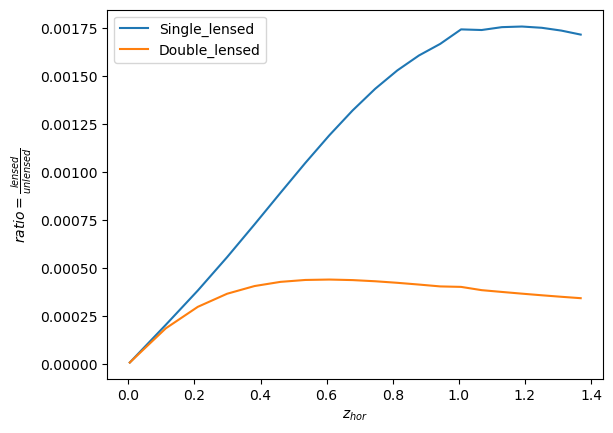

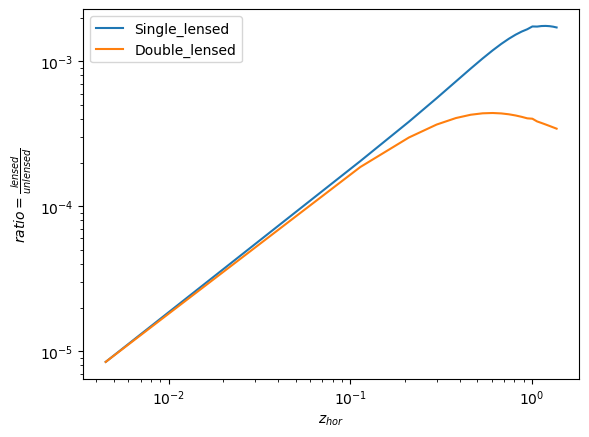

In [72]:
fig, ax = plt.subplots()
ax.plot(z_hor_, R_sl/R_u, label="Single_lensed")
ax.plot(z_hor_, R_sl2/R_u2, label="Double_lensed")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.loglog(z_hor_, R_sl/R_u, label="Single_lensed")
ax.loglog(z_hor_, R_sl2/R_u2, label="Double_lensed")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()

* at lower value of $D_{hor}$ or $z$, number of sigle image and double image detection is sort of the same
* reason: ??

# Using with sampling using lenstronomy

In [60]:
import cbcstatistics

In [61]:
nsamples=int(1e5)
statistics_lensed = cbcstatistics.LensStatisticsBNS(zmax=14)
samples_lensed = statistics_lensed.draw_samples(nsamples, seed=1)

In [63]:
# mu0: mu of the more amplified image 
# mu0>2
mu0, mu1 = samples_lensed['mu']

## Single image case
* monte-carlo integration 
$$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}] = \left<\Theta[c<\sqrt{\mu}]\right>_{\mu\in P(\mu)} $$
* where $c=\frac{D_l}{D_{hor}}$
* where, $<...>$ means averaging

In [80]:
# considering only L1 
# montecarlo integration
def bool_inte(z, mu_arr, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    
    # monte-carlo integration
    # averaging
    mu_arr = np.sqrt(mu_arr)
    bool_lens = len(mu_arr[mu_arr>dratio])/len(mu_arr)
    #print(dratio)
    return(bool_lens)

In [74]:
# analytical integration
def Bool_lensed(z, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    if(dratio<=np.sqrt(2)):
        bool_lens = 1.
    else:
        bool_lens = (-1+dratio**2)**-2
    
    return(bool_lens)

In [75]:
def integrand_monte(z, mu_arr, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*bool_inte(z, mu_arr, dhor_) )
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [83]:
# results with varing Dhor = [20,10000]Mpc
dhor_original = np.linspace(20,10000,20)
R_sl_ = []
R_u_ = []
for ii in dhor_original:
    R_sl_.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])
    R_u_.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_sl_ = np.array(R_sl_)
R_u_ = np.array(R_u_)

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_2233/3587227647.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R_sl_.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])


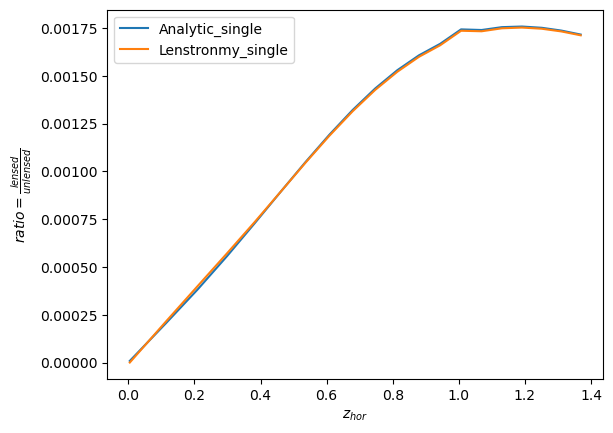

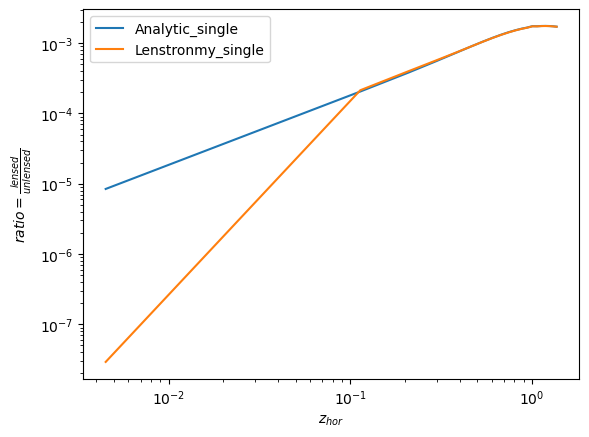

In [85]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

fig, ax = plt.subplots()
ax.plot(z_hor_, R_sl/R_u, label="Analytic_single")
ax.plot(z_hor_, R_sl_/R_u_, label="Lenstronmy_single")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.loglog(z_hor_, R_sl/R_u, label="Analytic_single")
ax.loglog(z_hor_, R_sl_/R_u_, label="Lenstronmy_single")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()

## Double image case
* monte-carlo integration 
$$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}] = \left<\Theta[(c1<\sqrt{\mu})\;\&\;(c2<\sqrt{\mu})]\right>_{\mu\in P(\mu)} $$
* where $c=\frac{D_l}{D_{hor}}$; c1,c2 for first and second image
* where, $<...>$ means averaging

In [86]:
# considering only L1 
# montecarlo integration
# mu_arr1, mu_arr2 have the same size
def bool_inte(z, mu_arr1, mu_arr2, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    
    # monte-carlo integration
    # averaging
    mu_arr1 = np.sqrt(mu_arr1)
    mu_arr2 = np.sqrt(mu_arr2)
    bool_lens = len(mu_arr1[(mu_arr1>dratio)&(mu_arr2>dratio)])/len(mu_arr1)
    #print(dratio)
    return(bool_lens)

In [87]:
# only the lensed in
def integrand_monte(z, mu_arr1, mu_arr2, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*bool_inte(z, mu_arr1, mu_arr2, dhor_) )
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [89]:
# results with varing Dhor = [20,10000]Mpc
dhor_original = np.linspace(20,10000,20)
R_sl_2 = []
R_u_2 = []
for ii in dhor_original:
    R_sl_2.append(quad(integrand_monte, 0., np.inf, args=(mu0,mu1,ii))[0])
    R_u_2.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_sl_2 = np.array(R_sl_2)
R_u_2 = np.array(R_u_2)

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_2233/459896379.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R_sl_2.append(quad(integrand_monte, 0., np.inf, args=(mu0,mu1,ii))[0])


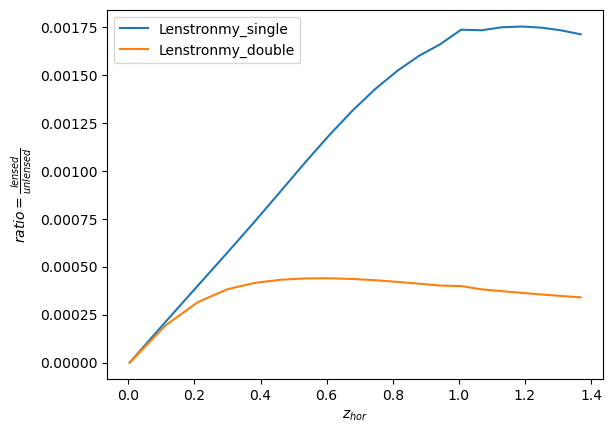

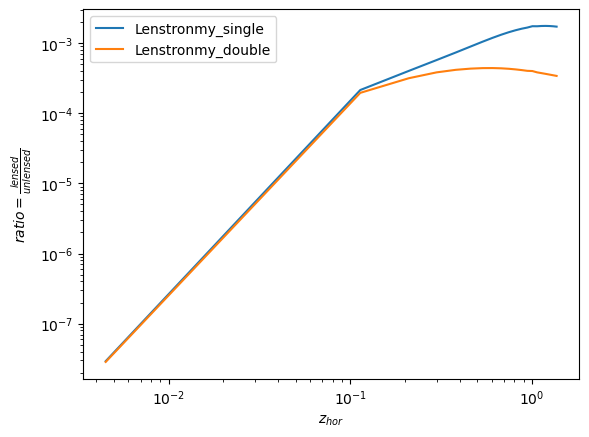

In [91]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

fig, ax = plt.subplots()
ax.plot(z_hor_, R_sl_/R_u_, label="Lenstronmy_single")
ax.plot(z_hor_, R_sl_2/R_u_2, label="Lenstronmy_double")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.loglog(z_hor_, R_sl_/R_u_, label="Lenstronmy_single")
ax.loglog(z_hor_, R_sl_2/R_u_2, label="Lenstronmy_double")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()

## Modified sampling (Uniform), Single image case
* monte-carlo integration 
* if $P_o(\mu)$ is a uniform PDF
$$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}] = \int_2^\infty d\mu P_o(\mu)\frac{P(\mu)}{P_o(\mu)}\Theta[c<\sqrt{\mu}] = \left<\frac{P(\mu)}{P_o(\mu)}\Theta[c<\sqrt{\mu}]\right>_{\mu\in P_o(\mu)} $$
* where $c=\frac{D_l}{D_{hor}}$
$$P(\mu)=\frac{2}{(-1+\mu)^3}$$
* let $P_o(\mu)=\text{Uniform}(2,1000)=\frac{1}{998}$
* where, $<...>$ means averaging

In [109]:
# probability distribution of lensing amplification
def mu_pdf(mu_):
    return( 2/(-1+mu_)**3 )

In [114]:
# considering only L1 
# montecarlo integration
# mu_arr is sampled from Po(mu)
def bool_inte(z, mu_arr, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    
    # monte-carlo integration
    # averaging
    sqrt_mu = np.sqrt(mu_arr)
    mu_bool = mu_arr[sqrt_mu>dratio] #selecting elements that satisfy the condition

    bool_lens = np.sum(mu_pdf(mu_bool))*9998/len(mu_arr)
    #print(dratio)
    return(bool_lens)

In [115]:
# if uniform sampling is used
mu0 = np.random.uniform(2,1e4,100000)

In [116]:
def integrand_monte(z, mu_arr, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*bool_inte(z, mu_arr, dhor_) )
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [117]:
# results with varing Dhor = [20,10000]Mpc
dhor_original = np.linspace(20,10000,20)
Rsl_ = []
Ru_ = []
for ii in dhor_original:
    Rsl_.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])
    Ru_.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
Rsl_ = np.array(Rsl_)
Ru_ = np.array(Ru_)

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_2233/3824076642.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Rsl_.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])


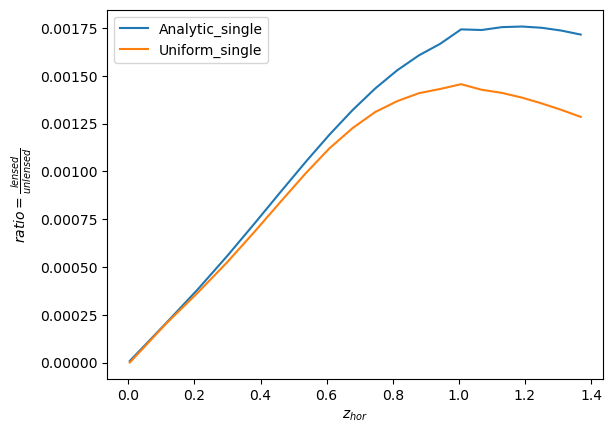

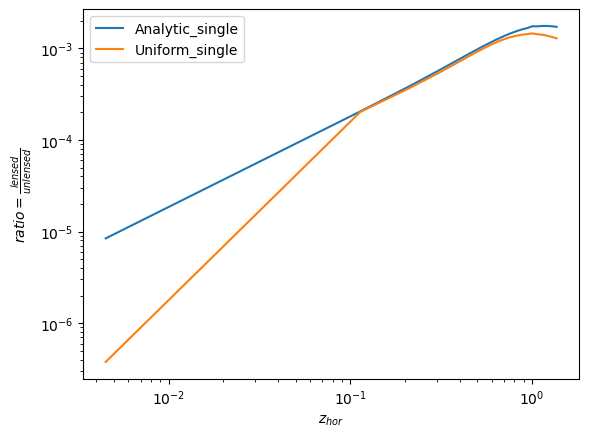

In [119]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

fig, ax = plt.subplots()
ax.plot(z_hor_, R_sl/R_u, label="Analytic_single")
ax.plot(z_hor_, Rsl_/Ru_, label="Uniform_single")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.loglog(z_hor_, R_sl/R_u, label="Analytic_single")
ax.loglog(z_hor_, Rsl_/Ru_, label="Uniform_single")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()

## Modified sampling (Uniform), double image case
* monte-carlo integration 
* if $P_o(\mu)$ is a uniform PDF
$$\int_2^\infty d\mu P(\mu)\Theta[c<\sqrt{\mu}] = \int_2^\infty d\mu P_o(\mu)\frac{P(\mu)}{P_o(\mu)}\Theta[c<\sqrt{\mu}] = \left<\frac{P(\mu)}{P_o(\mu)}\Theta[c<\sqrt{\mu}]\right>_{\mu\in P_o(\mu)} $$
* where $c=\frac{D_l}{D_{hor}}$
$$P(\mu)=\frac{2}{(1+\mu)^3}$$
* let $P_o(\mu)=\text{Uniform}(2,1000)=\frac{1}{998}$
* where, $<...>$ means averaging

In [103]:
# probability distribution of lensing amplification
def mu_pdf(mu_):
    return( 2/(1+mu_)**3 )

In [104]:
# considering only L1 
# montecarlo integration
# mu_arr is sampled from Po(mu)
def bool_inte(z, mu_arr, dhor_ori):
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    dratio = Dl/dhor
    
    # monte-carlo integration
    # averaging
    sqrt_mu = np.sqrt(mu_arr)
    mu_bool = mu_arr[sqrt_mu>dratio] #selecting elements that satisfy the condition

    bool_lens = np.sum(mu_pdf(mu_bool))*998/len(mu_arr)
    #print(dratio)
    return(bool_lens)

In [105]:
# if uniform sampling is used
mu0 = np.random.uniform(1,1e3,100000)

In [106]:
def integrand_monte(z, mu_arr, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*bool_inte(z, mu_arr, dhor_) )
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [107]:
# results with varing Dhor = [20,10000]Mpc
dhor_original = np.linspace(20,10000,20)
Rsl_2 = []
Ru_2 = []
for ii in dhor_original:
    Rsl_2.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])
    Ru_2.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
Rsl_2 = np.array(Rsl_2)
Ru_2 = np.array(Ru_2)

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_2233/224223564.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Rsl_2.append(quad(integrand_monte, 0., np.inf, args=(mu0,ii))[0])


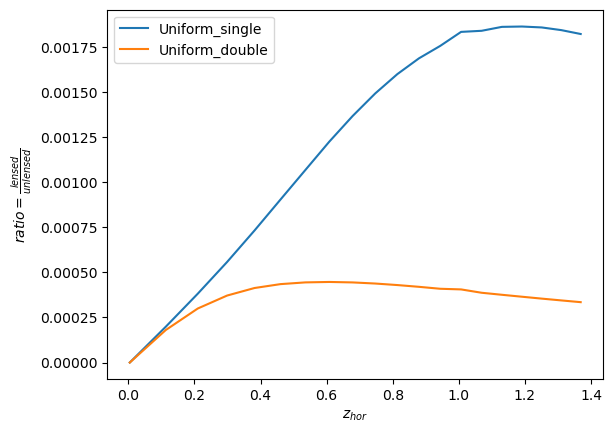

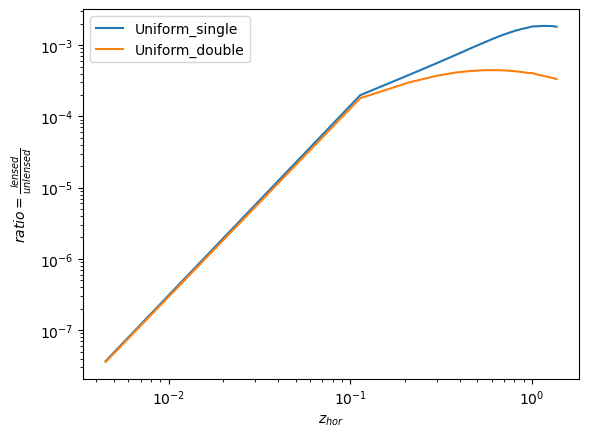

In [108]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

fig, ax = plt.subplots()
ax.plot(z_hor_, Rsl_/Ru_, label="Uniform_single")
ax.plot(z_hor_, Rsl_2/Ru_2, label="Uniform_double")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.loglog(z_hor_, Rsl_/Ru_, label="Uniform_single")
ax.loglog(z_hor_, Rsl_2/Ru_2, label="Uniform_double")
ax.set_ylabel(r"$ratio=\frac{lensed}{unlensed}$")
ax.set_xlabel(r"$z_{hor}$")
ax.legend()
plt.show()